# Lab 06 - DOCUMENT CLUSTERING 

In [0]:
#Release: 1.1909.0901

<br>
 
***If you use Google Colab, install sastrawi package***

In [1]:
!pip install sastrawi

     |████████████████████████████████| 215kB 5.0MB/s 


<br>

#### Import required library

In [0]:

import nltk
from bs4 import BeautifulSoup
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
#from sklearn.externals import joblib
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

<br>
 
***If you use Google Colab, download stopwords dan punkt package***

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

<br>

#### Download dataset from github

In [4]:
!git clone https://github.com/project303/dataset.git

Cloning into 'dataset'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [5]:
!ls dataset

 Berita.txt  'Judul Berita.txt'   nasa-web-access-19950701.log	 Twitter.csv


<br>

### Step 01 - Read dataset

In [6]:
#load titles
titles = open('dataset/Judul Berita.txt').read().split('\n')
len(titles)

31

In [7]:
titles[:10]

['Nasabah Bank Mandiri Mengaku Uangnya Raib Rp49 Juta',
 'Mata Uang dan Bursa Saham Asia Ciut Jelang Pengumuman The Fed',
 'Polisi Tindaklanjuti Kasus Dugaan Pemukulan Herman Hery',
 'Terduga Teroris di Bandung Barat Dibekuk di Rumah Makan Sunda',
 'Lloris: Kemenangan Atas Peru Bakal Beri Kepercayaan Diri',
 'Klasemen Sementara Grup A Piala Dunia 2018',
 'Kebijakan Suku Bunga ECB Lemahkan Euro dan Bursa Eropa',
 '2019, Bantuan Program Keluarga Harapan Naik jadi Rp3,5 Juta',
 "Habiburokhman Lapor Balik ke Bareskrim soal Mudik 'Neraka'",
 'Novel Ungkit Lagi Dugaan Oknum Jenderal dalam Teror Air Keras']

In [8]:
print(titles)

['Nasabah Bank Mandiri Mengaku Uangnya Raib Rp49 Juta', 'Mata Uang dan Bursa Saham Asia Ciut Jelang Pengumuman The Fed', 'Polisi Tindaklanjuti Kasus Dugaan Pemukulan Herman Hery', 'Terduga Teroris di Bandung Barat Dibekuk di Rumah Makan Sunda', 'Lloris: Kemenangan Atas Peru Bakal Beri Kepercayaan Diri', 'Klasemen Sementara Grup A Piala Dunia 2018', 'Kebijakan Suku Bunga ECB Lemahkan Euro dan Bursa Eropa', '2019, Bantuan Program Keluarga Harapan Naik jadi Rp3,5 Juta', "Habiburokhman Lapor Balik ke Bareskrim soal Mudik 'Neraka'", 'Novel Ungkit Lagi Dugaan Oknum Jenderal dalam Teror Air Keras', 'Lemparan Salto Gagal Bek Timnas Iran Viral di Media Sosial', 'Target McIlroy Menjadi Pegolf Terbaik dari Generasinya', 'Dibuka Rp14.107 per Dolar AS, Rupiah Bakal Betah Melemah', 'Masih Banyak Perusahaan Tunggak Bayar THR Usai Lebaran', 'Asing Jual Bersih Rp2 Triliun, IHSG Ditutup Anjlok 1,8 Persen', 'KPK Periksa Pejabat Agung Podomoro Terkait Kasus Bupati Rita', 'Tiga Bos First Travel Hadapi Tunt

In [9]:
article = open('dataset/Berita.txt', encoding="utf8").read().split('BERHENTI DISINI')
len(article)

32

In [10]:
article = article[:31]
print(article)

['<html lang="en">\n\n    <head>\n    <title>Kroasia: Melawan Argentina adalah Pertandingan Termudah</title>\n<meta charset="utf-8">\n<meta http-equiv="X-UA-Compatible" content="IE=edge">\n<meta name="robots" content="index, follow" />\n\n\nJakarta, CNN Indonesia -- Agung Rahman, seorang nasabah Bank Mandiri di Karawang mengaku tiba-tiba kehilangan uang di rekening banknya. Akibat kejadian tersebut dia mengalami kerugian hampir Rp49 juta.\n\nAgung mengatakan sebelum kejadian tersebut saldo tabungan yang telah dihimpunnya selama setahun tersebut mencapai Rp49.667.000. Pada 10 Juni lalu, dia terakhir kali mengecek tabungan tersebut.\n\nNamun, sontak ia kaget. Pasalnya, sisa saldo di tabungannya tinggal Rp832.324.\n\n"Jadi, tiba- tiba hilang," katanya seperti dikutip dari Antara, Selasa (12/6).\n\nAgung kaget karena saldo tersebut berkurang banyak tanpa ia melakukan transaksi sama sekali. Ia mengklaim sudah berupaya mengecek ke Bank Mandiri.\n\nDari hasil pengecekan tersebut Bank Mandiri 

In [11]:
article_clean = []
for text in article:
    text = BeautifulSoup(text, 'html.parser').getText()
    article_clean.append(text)
article = article_clean
print(article)

['\n\nKroasia: Melawan Argentina adalah Pertandingan Termudah\n\n\n\n\n\nJakarta, CNN Indonesia -- Agung Rahman, seorang nasabah Bank Mandiri di Karawang mengaku tiba-tiba kehilangan uang di rekening banknya. Akibat kejadian tersebut dia mengalami kerugian hampir Rp49 juta.\n\nAgung mengatakan sebelum kejadian tersebut saldo tabungan yang telah dihimpunnya selama setahun tersebut mencapai Rp49.667.000. Pada 10 Juni lalu, dia terakhir kali mengecek tabungan tersebut.\n\nNamun, sontak ia kaget. Pasalnya, sisa saldo di tabungannya tinggal Rp832.324.\n\n"Jadi, tiba- tiba hilang," katanya seperti dikutip dari Antara, Selasa (12/6).\n\nAgung kaget karena saldo tersebut berkurang banyak tanpa ia melakukan transaksi sama sekali. Ia mengklaim sudah berupaya mengecek ke Bank Mandiri.\n\nDari hasil pengecekan tersebut Bank Mandiri menyatakan bahwa berkurangnya saldo tabungan Agung terjadi akibat transaksi di rekeningnya.\n\n"Tapi ini janggal, karena saya merasa tidak pernah melakukan transaksi se

In [12]:
print(str(len(titles)) + ' titles')

31 titles


In [13]:
print(str(len(article)) + ' article')

31 article


<br>

### Step 02 - Tokenization

In [0]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [0]:
totalvocab_tokenized = []
for i in article:
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [16]:
print(len(totalvocab_tokenized))

10063


In [17]:
print(totalvocab_tokenized)

['kroasia', 'melawan', 'argentina', 'adalah', 'pertandingan', 'termudah', 'jakarta', 'cnn', 'indonesia', 'agung', 'rahman', 'seorang', 'nasabah', 'bank', 'mandiri', 'di', 'karawang', 'mengaku', 'tiba-tiba', 'kehilangan', 'uang', 'di', 'rekening', 'banknya', 'akibat', 'kejadian', 'tersebut', 'dia', 'mengalami', 'kerugian', 'hampir', 'rp49', 'juta', 'agung', 'mengatakan', 'sebelum', 'kejadian', 'tersebut', 'saldo', 'tabungan', 'yang', 'telah', 'dihimpunnya', 'selama', 'setahun', 'tersebut', 'mencapai', 'rp49.667.000', 'pada', 'juni', 'lalu', 'dia', 'terakhir', 'kali', 'mengecek', 'tabungan', 'tersebut', 'namun', 'sontak', 'ia', 'kaget', 'pasalnya', 'sisa', 'saldo', 'di', 'tabungannya', 'tinggal', 'rp832.324', 'jadi', 'tiba-', 'tiba', 'hilang', 'katanya', 'seperti', 'dikutip', 'dari', 'antara', 'selasa', 'agung', 'kaget', 'karena', 'saldo', 'tersebut', 'berkurang', 'banyak', 'tanpa', 'ia', 'melakukan', 'transaksi', 'sama', 'sekali', 'ia', 'mengklaim', 'sudah', 'berupaya', 'mengecek', 'ke'

<br>

### Step 03 - Stemming

In [0]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [0]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [0]:
totalvocab_stemmed = []
for i in article:
    
    allwords_stemmed = tokenize_and_stem(i) # for each item in 'article', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) # extend the 'totalvocab_stemmed' list

In [21]:
print(len(totalvocab_stemmed))

10063


In [22]:
print(totalvocab_stemmed)

['kroasia', 'lawan', 'argentina', 'adalah', 'tanding', 'mudah', 'jakarta', 'cnn', 'indonesia', 'agung', 'rahman', 'orang', 'nasabah', 'bank', 'mandiri', 'di', 'karawang', 'aku', 'tiba', 'hilang', 'uang', 'di', 'rekening', 'bank', 'akibat', 'jadi', 'sebut', 'dia', 'alami', 'rugi', 'hampir', 'rp49', 'juta', 'agung', 'kata', 'belum', 'jadi', 'sebut', 'saldo', 'tabung', 'yang', 'telah', 'himpun', 'lama', 'tahun', 'sebut', 'capai', 'rp49 667 000', 'pada', 'juni', 'lalu', 'dia', 'akhir', 'kali', 'ecek', 'tabung', 'sebut', 'namun', 'sontak', 'ia', 'kaget', 'pasal', 'sisa', 'saldo', 'di', 'tabung', 'tinggal', 'rp832 324', 'jadi', 'tiba-', 'tiba', 'hilang', 'kata', 'seperti', 'kutip', 'dari', 'antara', 'selasa', 'agung', 'kaget', 'karena', 'saldo', 'sebut', 'kurang', 'banyak', 'tanpa', 'ia', 'laku', 'transaksi', 'sama', 'sekali', 'ia', 'klaim', 'sudah', 'upaya', 'ecek', 'ke', 'bank', 'mandiri', 'dari', 'hasil', 'kece', 'sebut', 'bank', 'mandiri', 'nyata', 'bahwa', 'kurang', 'saldo', 'tabung', '

In [23]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('ada ' + str(vocab_frame.shape[0]) + ' kata di vocab_frame')
print(vocab_frame.head())

ada 10063 kata di vocab_frame
                  words
kroasia         kroasia
lawan           melawan
argentina     argentina
adalah           adalah
tanding    pertandingan


<br>

### Step 04 - TF-IDF

In [24]:
ranks = []
for i in range(1, len(titles)+1):
    ranks.append(i)

ranks

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [25]:
stopwords = nltk.corpus.stopwords.words('indonesian')

print('number of stopwords: ' + str(len(stopwords)))
#stopwords

number of stopwords: 758


In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words = stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [27]:
get_ipython().magic(u'time tfidf_matrix = tfidf_vectorizer.fit_transform(article) #fit the vectorizer to article')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arti', 'asa', 'buah', 'bum', 'enak', 'hadap', 'ikan', 'ira', 'jenak', 'kali', 'kena', 'kerja', 'khusus', 'laku', 'langsung', 'lihat', 'maksud', 'masuk', 'mena', 'nyata', 'olah', 'orang', 'rupa', 'sampa', 'sangkut', 'sekal', 'sekira', 'sin', 'tuju', 'upa', 'utama'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 5.83 s, sys: 4.99 ms, total: 5.84 s
Wall time: 5.88 s


In [28]:
print(tfidf_matrix.shape)

(31, 49)


In [29]:
print(tfidf_matrix)

  (0, 11)	0.22302319489050143
  (0, 4)	0.2131966119684082
  (0, 31)	0.24602953707788602
  (0, 34)	0.23388597834082864
  (0, 26)	0.22302319489050143
  (0, 8)	0.1959731546337647
  (0, 16)	0.6496870086351433
  (0, 15)	0.22302319489050143
  (0, 12)	0.24602953707788602
  (0, 10)	0.2131966119684082
  (0, 2)	0.22302319489050143
  (0, 46)	0.1959731546337647
  (0, 27)	0.18833254231877586
  (1, 32)	0.03747861061358831
  (1, 1)	0.04092825607048697
  (1, 28)	0.21460873649329776
  (1, 38)	0.04092825607048697
  (1, 9)	0.034561976937928666
  (1, 23)	0.0391249238998992
  (1, 47)	0.04092825607048697
  (1, 29)	0.8991037299651594
  (1, 40)	0.0858434945973191
  (1, 45)	0.11243583184076492
  (1, 0)	0.04515028089060861
  (1, 35)	0.09030056178121722
  :	:
  (29, 41)	0.10843046135067562
  (29, 3)	0.197677579118902
  (29, 29)	0.8176853417218839
  (29, 45)	0.09467981373956372
  (29, 24)	0.10843046135067562
  (29, 2)	0.4135777285227237
  (29, 46)	0.1817078537159742
  (30, 20)	0.4289897772703442
  (30, 14)	0.3333

In [30]:
terms = tfidf_vectorizer.get_feature_names()
len(terms)

49

In [0]:
similarity = cosine_similarity(tfidf_matrix)

In [32]:
similarity

array([[1.        , 0.13666662, 0.44220397, 0.19388398, 0.07691373,
        0.06701427, 0.07711305, 0.22819353, 0.46391556, 0.36463955,
        0.35072591, 0.07515389, 0.08189864, 0.13368386, 0.04544306,
        0.16731091, 0.33398522, 0.22491678, 0.12498601, 0.23583646,
        0.14182651, 0.28757773, 0.30084585, 0.2067153 , 0.48633153,
        0.52209946, 0.61142873, 0.1255454 , 0.06276799, 0.12784729,
        0.14064507],
       [0.13666662, 1.        , 0.05870598, 0.04087727, 0.05866207,
        0.04290615, 0.83932773, 0.20223218, 0.06392403, 0.07234711,
        0.01176853, 0.06560805, 0.93685095, 0.12685719, 0.86493313,
        0.18696286, 0.19591612, 0.12393536, 0.10115527, 0.13486763,
        0.06517895, 0.64339258, 0.80863783, 0.47720501, 0.03646238,
        0.02500333, 0.01986498, 0.0780258 , 0.01448315, 0.81127422,
        0.68698439],
       [0.44220397, 0.05870598, 1.        , 0.42557997, 0.04071455,
        0.03364451, 0.06107431, 0.04585562, 0.37987685, 0.60905543,
      

<br>

### Step 05 - K-Means Modelling

In [33]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters, random_state=1000)
get_ipython().magic(u'time km.fit(tfidf_matrix)')
clusters = km.labels_.tolist()
#clusters

CPU times: user 53.6 ms, sys: 2.97 ms, total: 56.6 ms
Wall time: 62.9 ms


In [34]:
news = { 'title': titles, 'rank': ranks, 'article': article, 'cluster': clusters }
frame = pd.DataFrame(news, index = [clusters] , columns = ['rank', 'title', 'cluster'])
print(frame) 
frame['cluster'].value_counts() 

   rank                                              title  cluster
2     1  Nasabah Bank Mandiri Mengaku Uangnya Raib Rp49...        2
1     2  Mata Uang dan Bursa Saham Asia Ciut Jelang Pen...        1
2     3  Polisi Tindaklanjuti Kasus Dugaan Pemukulan He...        2
2     4  Terduga Teroris di Bandung Barat Dibekuk di Ru...        2
0     5  Lloris: Kemenangan Atas Peru Bakal Beri Keperc...        0
0     6         Klasemen Sementara Grup A Piala Dunia 2018        0
1     7  Kebijakan Suku Bunga ECB Lemahkan Euro dan Bur...        1
2     8  2019, Bantuan Program Keluarga Harapan Naik ja...        2
2     9  Habiburokhman Lapor Balik ke Bareskrim soal Mu...        2
2    10  Novel Ungkit Lagi Dugaan Oknum Jenderal dalam ...        2
0    11  Lemparan Salto Gagal Bek Timnas Iran Viral di ...        0
0    12  Target McIlroy Menjadi Pegolf Terbaik dari Gen...        0
1    13  Dibuka Rp14.107 per Dolar AS, Rupiah Bakal Bet...        1
2    14  Masih Banyak Perusahaan Tunggak Bayar T

2    13
1     9
0     9
Name: cluster, dtype: int64

In [35]:
grouped = frame['rank'].groupby(frame['cluster']) 
grouped.mean()

cluster
0    16.777778
1    18.555556
2    13.692308
Name: rank, dtype: float64

In [36]:
print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print()

Top terms per cluster:
Cluster 0 words: b'dunia', b'pemain', b'menang', b'poin', b'posisi', b'tim',

Cluster 0 titles: Lloris: Kemenangan Atas Peru Bakal Beri Kepercayaan Diri, Klasemen Sementara Grup A Piala Dunia 2018, Lemparan Salto Gagal Bek Timnas Iran Viral di Media Sosial, Target McIlroy Menjadi Pegolf Terbaik dari Generasinya, Juara British Terbuka, Stenson Lampaui Rekor Tiger Woods, Tiger Woods Putuskan Vakum dari Turnamen Golf, Juara GP Kanada, Vettel Kembali Pimpin Klasemen F1 2018, Sebastian Vettel Menjuarai Grand Prix F1 di Singapura, Kroasia: Melawan Argentina adalah Pertandingan Termudah,

Cluster 1 words: b'persen', b'uang', b'mencapai', b'catatan', b'mei', b'negara-negara',

Cluster 1 titles: Mata Uang dan Bursa Saham Asia Ciut Jelang Pengumuman The Fed, Kebijakan Suku Bunga ECB Lemahkan Euro dan Bursa Eropa, Dibuka Rp14.107 per Dolar AS, Rupiah Bakal Betah Melemah, Asing Jual Bersih Rp2 Triliun, IHSG Ditutup Anjlok 1,8 Persen, Darmin Nyatakan, Pelemahan Rupiah Tak Per

<br>

### Step 06 - Visualization

In [37]:
similarity_distance = 1 - cosine_similarity(tfidf_matrix)
print(type(similarity_distance))
print(similarity_distance.shape)

<class 'numpy.ndarray'>
(31, 31)


In [38]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
get_ipython().magic(u'time pos = mds.fit_transform(similarity_distance)  # shape (n_components, n_samples)')
print(pos.shape)
print(pos)
xs, ys = pos[:, 0], pos[:, 1]
print(type(xs))
xs

CPU times: user 52.7 ms, sys: 2 ms, total: 54.7 ms
Wall time: 72.3 ms
(31, 2)
[[-0.05434651 -0.28189828]
 [-0.17209015  0.51523701]
 [-0.19878807 -0.59794167]
 [-0.45436029 -0.49134784]
 [ 0.58826494 -0.23431686]
 [ 0.59271115  0.01648729]
 [-0.22023873  0.52778557]
 [-0.56145614  0.17671219]
 [ 0.08130479 -0.64673421]
 [-0.37062421 -0.4179295 ]
 [ 0.36500855 -0.22289639]
 [ 0.61861768  0.35728855]
 [-0.13750193  0.50505848]
 [-0.66314681  0.03464265]
 [-0.14702084  0.55419675]
 [-0.54368957 -0.18500665]
 [-0.41886036 -0.0782765 ]
 [ 0.28460293 -0.52530031]
 [ 0.38981988  0.19548965]
 [ 0.29115381 -0.06438992]
 [ 0.5840928   0.25403773]
 [-0.04663573  0.29826923]
 [-0.1940192   0.36639004]
 [ 0.09598726  0.58679033]
 [-0.17233939 -0.54080363]
 [-0.03241769 -0.45065332]
 [-0.14072521 -0.39809899]
 [ 0.66999505  0.11394753]
 [ 0.58991625 -0.29157607]
 [-0.29418056  0.50799625]
 [-0.32903369  0.41684092]]
<class 'numpy.ndarray'>


array([-0.05434651, -0.17209015, -0.19878807, -0.45436029,  0.58826494,
        0.59271115, -0.22023873, -0.56145614,  0.08130479, -0.37062421,
        0.36500855,  0.61861768, -0.13750193, -0.66314681, -0.14702084,
       -0.54368957, -0.41886036,  0.28460293,  0.38981988,  0.29115381,
        0.5840928 , -0.04663573, -0.1940192 ,  0.09598726, -0.17233939,
       -0.03241769, -0.14072521,  0.66999505,  0.58991625, -0.29418056,
       -0.32903369])

In [0]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

In [0]:
#set up cluster names using a dict
cluster_names = {0: 'Olahraga', 
                 1: 'Ekonomi', 
                 2: 'Kriminal'}

In [0]:
matplotlib inline

In [0]:
#some ipython magic to show the matplotlib plots inline
get_ipython().magic(u'matplotlib inline')

In [43]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

print(df[1:10])

          x         y  label                                              title
1 -0.172090  0.515237      1  Mata Uang dan Bursa Saham Asia Ciut Jelang Pen...
2 -0.198788 -0.597942      2  Polisi Tindaklanjuti Kasus Dugaan Pemukulan He...
3 -0.454360 -0.491348      2  Terduga Teroris di Bandung Barat Dibekuk di Ru...
4  0.588265 -0.234317      0  Lloris: Kemenangan Atas Peru Bakal Beri Keperc...
5  0.592711  0.016487      0         Klasemen Sementara Grup A Piala Dunia 2018
6 -0.220239  0.527786      1  Kebijakan Suku Bunga ECB Lemahkan Euro dan Bur...
7 -0.561456  0.176712      2  2019, Bantuan Program Keluarga Harapan Naik ja...
8  0.081305 -0.646734      2  Habiburokhman Lapor Balik ke Bareskrim soal Mu...
9 -0.370624 -0.417930      2  Novel Ungkit Lagi Dugaan Oknum Jenderal dalam ...


In [44]:
# group by cluster
# this generate {name:group(which is a dataframe)}
groups = df.groupby('label')
print(groups.groups)

{0: Int64Index([4, 5, 10, 11, 18, 19, 20, 27, 28], dtype='int64'), 1: Int64Index([1, 6, 12, 14, 21, 22, 23, 29, 30], dtype='int64'), 2: Int64Index([0, 2, 3, 7, 8, 9, 13, 15, 16, 17, 24, 25, 26], dtype='int64')}


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


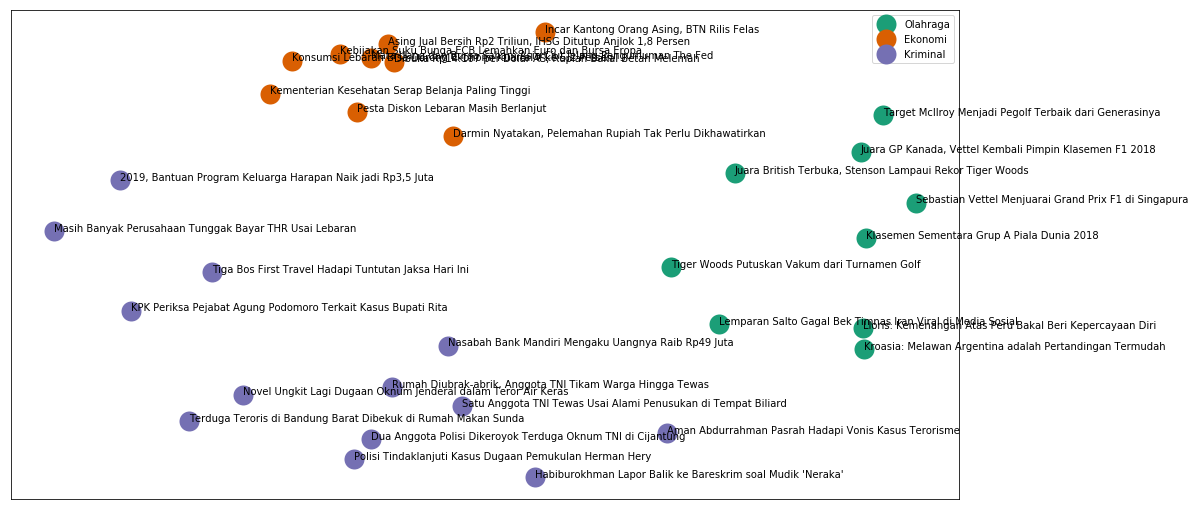

In [45]:
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
# ms: marker size
for name, group in groups:
    #print("*******")
    #print("group name " + str(name))
    #print(group)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=10)  

plt.show()